#                                                  Assignment 1 

## Habiba Elhussein             -  ID: 37-0846                 -   T.14
## Mayar Lotfy                       - ID: 37-4473                  -   T.13

##### Libraries Installation

In [47]:
! pip install matplotlib
! pip install matlab
! pip install numpy
! pip install scipy
! pip install pillow


In [53]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matlab.engine
import sys
from scipy import signal
from PIL import Image

eng = matlab.engine.start_matlab()


## Helper Functions:

In [3]:
def writeFile(fileName, beats,time):
    with open(fileName, 'w') as f:
        for x in range(0, len(time)):
            f.write("Beat Number : '{0}' is missing in Timpe Stamp '{1}' \n".format( beats[x] , time[x]))

In [4]:
def plot_fig(time,Data,outputFileName,peaks=None) :
    if(peaks is None):
        eng.plot(matlab.double(time.tolist()),matlab.double(Data.tolist()))  #create a plot
        eng.xlabel('Time in mSecs')
        eng.ylabel('Signal voltage')
        eng.savefig(outputFileName+".fig",nargout=0)    #save current figure to "foo.fig"
    else:
        eng.plot(matlab.double(time.tolist()),matlab.double(Data.tolist()), '-*' , 'MarkerIndices', matlab.double(peaks.tolist()))
        eng.xlabel('Time in mSecs')
        eng.ylabel('Signal voltage')
        eng.savefig(outputFileName+".fig",nargout=0) 
#eng.close()  

In [5]:
def readData(fileName,N=None):
    lineList = list()
   
    lineList = [line.rstrip('\n') for line in open(fileName)]

    x = np.array(lineList)
    DataN = x.astype(np.float)

    if(N is None):
        N = len(DataN)
   
    DataN  = DataN[0:N]
    DataN.shape
    DataBcp =DataN
    return DataN
    

## Steps for Detecting the R wave:

#### 1. Notch filter: To remove Powerline noise (band stop filter for 50 HZ.)

In [6]:
# Required input defintions are as follows;
# band:   The bandwidth around the centerline freqency that you wish to filter
# freq:   The centerline frequency to be filtered
# ripple: The maximum passband ripple that is allowed in db
# order:  The filter order.  For FIR notch filters this is best set to 2 or 3,
#         IIR filters are best suited for high values of order.  This algorithm
#         is hard coded to FIR filters
# filter_type: 'butter', 'bessel', 'cheby1', 'cheby2', 'ellip'
# data:         the data to be filtered
def Implement_Notch_Filter(fs, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter

    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

In [7]:
 def notch_filter(data, lowcut, highcut, fs, order):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq

        i, u = signal.butter(order, [low, high], btype='bandstop')
        y = signal.lfilter(i, u, data)
        #print(len(y))
        return y

In [8]:
# ignore this cell

def notch_filter_temp(inputECG):
    #outputECG = [x for x in inputECG if(x <0.5)]
   # outputECG = inputECG[np.logical_and(inputECG<0.50,inputECG>0.5)]
   
   # outputECG = inputECG[np.logical_and(inputECG<=0.49,inputECG>=0.50)]
   # Do a Fourier transform on the signal

    tx  = np.fft.fft(inputECG);
    #print(len(tx))
    #outputECG = tx[np.logical_and(tx<=0.49,tx>=0.50)]
    itx = np.fft.ifft(tx);
    
    print(len(itx))
    return np.array(itx)


#### 2. Band Pass filter: To remove  noise (band pass filter from 0.1-45 HZ )

In [9]:
#ignore this cell
def band_filter(inputECG):
   #outputECG = [x for x in inputECG if(x !=0.5)]
    
    outputECG = inputECG[np.logical_and(inputECG>=0.01,inputECG<0.45)]
    #print(len(outputECG))
    return outputECG


In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

#### 3. Diffrentiate the Signal: to augment the gap between the signal and the noise (QRS becomes larger and noise becomes smaller)

In [11]:
def Def5point(f, Data):
    t = 1/f 
    y =list()
    y.append(Data[0])
    y.append(Data[1])

    for x in range(2, len(Data)-2):
        const = 1/(8*t)
        temp_before= - Data[x-2] - 2*Data[x-1]
        temp_after = 2*Data[x+1] + Data[x+2]
        
        y.append(temp_after+temp_before)
        
    y.append(Data[len(Data)-2])
    y.append(Data[len(Data)-1])
    return y
        
        
    

#### 4. Smoothing the signal

In [12]:
# testing the function in lecture
def smoothing(f,Data, window_length):
    t = 1/f
    y=list()
    y.append(Data[0:window_length]) #append first N-1 elements in the data 
    
    for x in range(window_length-1,len(Data)-1):
        data_slice = Data[x-window_length:x+1] # take a slice of data from x-N till N 
        average = np.average(data_slice)
        y.append(y)
        print(x)
    return y

In [13]:
def smooth_signal(data, sample_rate, window_length=None, polyorder=3):
    '''smooths given signal using savitzky-golay filter

    Function that smooths data using savitzky-golay filter using default settings.

    Functionality requested by Eirik Svendsen. Added since 1.2.4

    Parameters
    ----------
    data : 1d array or list
        array or list containing the data to be filtered

    sample_rate : int or float
        the sample rate with which data is sampled

    window_length : int or None
        window length parameter for savitzky-golay filter, see Scipy.signal.savgol_filter docs.
        Must be odd, if an even int is given, one will be added to make it uneven.
        default : 0.1  * sample_rate

    polyorder : int
        the order of the polynomial fitted to the signal. See scipy.signal.savgol_filter docs.
        default : 3

    Returns
    -------
    smoothed : 1d array
        array containing the smoothed data

    Examples
    --------
    Given a fictional signal, a smoothed signal can be obtained by smooth_signal():

    >>> x = [1, 3, 4, 5, 6, 7, 5, 3, 1, 1]
    >>> smoothed = smooth_signal(x, sample_rate = 2, window_length=4, polyorder=2)
    >>> np.around(smoothed[0:4], 3)
    array([1.114, 2.743, 4.086, 5.   ])

    If you don't specify the window_length, it is computed to be 10% of the 
    sample rate (+1 if needed to make odd)
    >>> import heartpy as hp
    >>> data, timer = hp.load_exampledata(0)
    >>> smoothed = smooth_signal(data, sample_rate = 100)

    '''

    if window_length == None:
        window_length = sample_rate // 10
        
    if window_length % 2 == 0 or window_length == 0: window_length += 1

    smoothed = signal.savgol_filter(data, window_length = window_length,
                             polyorder = polyorder)

    return smoothed

To get the peaks of the signal
We first compute the average of the signal (max(s) + min(s) ) /2 
next, we get a candidate threshold using that average.
then we compute (75 or more)  percentile of the filtered signal (computing only the percentiles without the earlier step will result to a very low value that is not peak since most of the values are actually low and not peak ). 

Our observation: The threshold value is dependant on the window length, and for a better setting of a window length the threshold should be fine (which is 25 (the sample rate // 10)). 


In [14]:
def getRPeaks(filtered_signal, N):
    avg_signal = (min(filtered_signal) +max(filtered_signal))/2
    peaks, _ = signal.find_peaks(filtered_signal, height=avg_signal,distance=N)
    
    #print("before",peaks.shape)
    peaks = peaks[1:len(peaks)]
    #print("after",peaks.shape)


    threshold2 = np.percentile(filtered_signal, 90,axis=0)
    #print("threshold2", threshold2)
    peaks, _ = signal.find_peaks(filtered_signal, height=threshold2, distance=25)
    #print(peaks.shape)
  #  eng.plot(matlab.double(filtered_signal.tolist()), '-*' , 'MarkerIndices', matlab.double(peaks.tolist())) 
    
    return peaks
   

In [15]:
def calculateRR (peaks,fs):
    RR = np.diff(peaks)
    RR = RR/fs
    RRms = np.multiply(RR,1000)
    #print("RR",RR)
    beats = np.arange(1,len(peaks),1)
    eng.plot(matlab.double(beats.tolist()),matlab.double(RRms.tolist()))  #create a plot
    eng.xlabel('Beats number') 
    eng.ylabel('Time in msecs') 
    eng.savefig("RR"+".fig",nargout=0)    #save current figure to "foo.fig"
    return RR

In [24]:
def filterNoise(signal,fs ):
    y = notch_filter(signal,49.9,50.1,fs,3)
    #plot_fig(y, "outputy")
    z = butter_bandpass_filter(y,0.1,45,fs)
    
    return z

In [75]:
def detectQRS(N,fs,fileName,Noise_Filter = True ,Samples=None,output_filename="out"):
    
    DataN = readData(fileName,Samples)
    if (Samples is None):
        Samples = len(DataN)
        
    time = np.arange(0,Samples*1/fs,1/fs)
    timems = np.multiply(time,1000)
    
    #y = notch_filter(DataN,49.9,50.1,fs,3)
    #z = butter_bandpass_filter(y,0.1,45,fs)
    if(Noise_Filter):
        u = filterNoise(DataN,fs)
    else:
        u = DataN
   
    u = Def5point(fs, u)

    u = np.square(u)

    u = smooth_signal(u,fs, window_length=N)
    #u=smoothing(fs,u, window_length=N)
    #plot_fig(u,"out1")
    #plot_fig(timems,np.array(u),"out1")
    
    
    peaks= getRPeaks(u,N)
     
    plot_fig(timems,u,output_filename,peaks)
         
    return peaks

    


In [17]:
def find_anomalies(random_data):
    # Set upper and lower limit to 3 standard deviation
    anomalies = []
    beatNumbers=[]
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    #print(lower_limit)
    # Generate outliers
    for x in range (0 ,len(random_data)):
        outlier = random_data[x]
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
            beatNumbers.append(x)
    return anomalies,beatNumbers

# Question 1 :

In [25]:
fileName = "D:\GUC\Semester 10\CSEN 1099 - Biomedical\Assignments\Assignment 1\DataN.txt"

##### Requirement 1 : Comparing Before and After Filter Changes: 

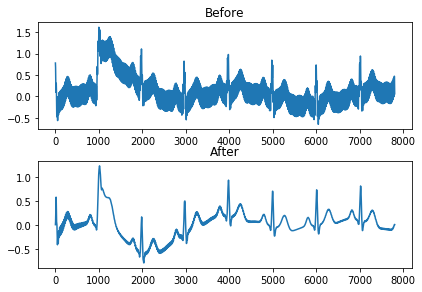

<Figure size 432x288 with 0 Axes>

In [64]:
fs = 256
Samples = 2000
signal_before = readData(fileName,N=Samples)
time = np.arange(0,Samples*1/fs,1/fs)
timems = np.multiply(time,1000)
filtered = filterNoise(signal_before,fs)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

#plt.figure()
plt.subplot(211)
plt.plot(timems, signal_before)
plt.title('Before')

plt.subplot(212)
plt.plot(timems, filtered)
plt.title('After')
plt.show()
plt.draw()
fig.savefig('Before_After_Filter.png')
im = Image.open('Before_After_Filter.png')
im = im.convert("RGB")
im.save('Before_After_Filter.jpg')
#plt.savefig('Before_After_Filter.jpg')

##### Requirement 2 : Using N=5 for the window length 

In [68]:
Samples = 2000
fs= 256
N =  5
outputfileName = 'DetectedR_5'
Rpeaks = detectQRS(N,fs,fileName,Noise_Filter= True,Samples=Samples,output_filename=outputfileName)


##### Requirement 3 : Using N=15 for the window length 

In [69]:
Samples = 2000
fs= 256
N =  15
outputfileName = 'DetectedR_15'
Rpeaks = detectQRS(N,fs,fileName,Noise_Filter= True,Samples=Samples,output_filename=outputfileName)

##### Requirement 4 : Using N=25 for the window length 

In [79]:
Samples = 2000
fs= 256
N =  25
outputfileName = 'DetectedR_25'
Rpeaks = detectQRS(N,fs,fileName,Noise_Filter= True,Samples=Samples,output_filename=outputfileName)

#### When we observed the past 3 figures to compare the different N values used, we concluded that the best N to use was the N = 25. N=25 resulted in the correct R peaks however, the N=15 and N=25 had faulty peaks when plotted. This is due to the sampling rate of this signal which is 256Hz, where N = 25 is the most accurate when smoothing the signal. In other words N = 25 is approximately equal to the widest QRS complex occured in this ECG signal.

##### Requirement 5 : Using N = 25 for window length but with no filtering 

In [84]:
Samples = 2000
fs= 256
N =  25
outputfileName = 'Unfiltered_25'
Rpeaks = detectQRS(N,fs,fileName,Noise_Filter= False,Samples=Samples,output_filename=outputfileName)

##### Requirement 6 : RR-plot Using N=5 for the window length 

In [86]:
Samples = 2000
fs= 256
N =  25
outputfileName = 'RR'
Rpeaks = detectQRS(N,fs,fileName,Noise_Filter= True,Samples=Samples,output_filename=outputfileName)
RR = calculateRR(np.array(Rpeaks),256)

# Question 2 :


##### In this question, Missing beats should be identified for a patient of Sinus Arrest. Our approach was to use the function detectQRS to identify the QRS complex in Data2 samples. Secondly, we calculated the RR intervals between each consecutive R peaks detected. The find anomalies algorithm is then applied to detect outliers, in other words, when a beat is missed a higher RR interval is detected compared to other normal RR intervals therefore, it is identified as a missing beat. 

In [87]:
Filename2= "D:\GUC\Semester 10\CSEN 1099 - Biomedical\Assignments\Assignment 1\Data2.txt"
OutputFilename= "D:\GUC\Semester 10\CSEN 1099 - Biomedical\Assignments\Assignment 1\MissingBeats.txt"

In [95]:
def detect_Sinus_Arrest(signal, window_length,fs=256 ):
    Rpeaks = detectQRS(window_length,fs,Filename2, Noise_Filter = True, output_filename= 'sinus_arrest')
    RR =calculateRR(np.array(Rpeaks),fs)
    anomalies, beatNumbers = find_anomalies(RR)
    print(beatNumbers)
    timeStamps = np.multiply(beatNumbers,(1/fs))

    return timeStamps,beatNumbers
    

In [96]:

fs = 256
N= 25
data = readData(Filename2)

timeStamps,beatNumbers = detect_Sinus_Arrest(signal=data,window_length=N)
print("time Stamps of the missing beats:" , timeStamps)
writeFile(OutputFilename,beatNumbers,timeStamps)


[4, 9, 21]
time Stamps of the missing beats: [0.015625   0.03515625 0.08203125]
